<a href="https://colab.research.google.com/github/Jawakar-7/Flower-Image-Classification/blob/main/Flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/Jawakar-7/Flower-Image-Classification

Cloning into 'Flower-Image-Classification'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), done.


In [2]:
! mkdir ~/.kaggle
! cp /content/Flower-Image-Classification/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kausthubkannan/5-flower-types-classification-dataset

 96% 233M/242M [00:04<00:00, 104MB/s]
100% 242M/242M [00:04<00:00, 61.2MB/s]


In [3]:

import zipfile
path= '/content/5-flower-types-classification-dataset.zip'  #  path to  zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')

In [4]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
test_path='/content/Image-Classification-using-multiple-models-/Datasets/seg_test/seg_test'
train_path='/content/Image-Classification-using-multiple-models-/Datasets/seg_train/seg_train'


In [5]:
data_path='/content/data/flower_images'

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

X_train = train_datagen.flow_from_directory(
    data_path,
    target_size=(150,150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32 ,# set as training data
    subset='training'
    )

X_test = train_datagen.flow_from_directory(
    data_path,
    target_size=(150,150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    subset='validation'
    ) # set as validation data


Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [8]:
labels={i:k for k,i in X_train.class_indices.items()}
for i,k in labels.items():
  print(f"{i}:{k}")


0:Lilly
1:Lotus
2:Orchid
3:Sunflower
4:Tulip


In [9]:

print(f"{len(X_train)} which is total images/32")

125 which is total images/32


In [10]:

for i,k in X_train:
  print(f"{i.shape}is a tuple that contains(batch size,target size and channel_size,) and k is the corresponding classe of  image {labels[np.argmax(k[0],axis=0)]} meaning the last class")
  break

(32, 150, 150, 3)is a tuple that contains(batch size,target size and channel_size,) and k is the corresponding classe of  image Lilly meaning the last class


In [11]:

X_train[0][1][0]

array([1., 0., 0., 0., 0.], dtype=float32)

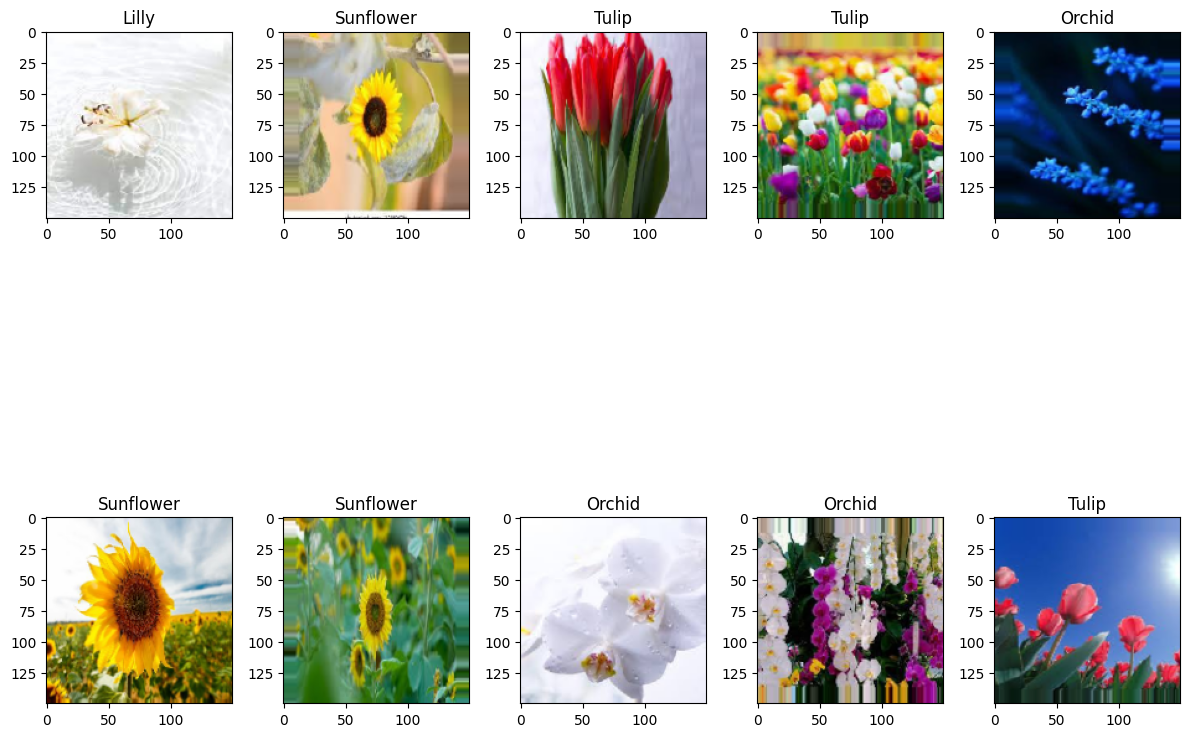

In [12]:
fig , ax=plt.subplots(ncols=5,nrows=2,figsize=(12,12))
t=0
for a in range(2):
    for  b in range(5):
      label=labels[np.argmax(X_train[0][1][t])]
      ax[a,b].set_title(label)
      ax[a,b].imshow(X_train[0][0][t][:,:,:])
      ax[a,b].axis='off'
      t+=1

plt.suptitle="Sample Training Images"
plt.tight_layout()

plt.show()

In [13]:

from keras.models import Sequential
from keras.layers import Activation , BatchNormalization , Dense , Dropout , Flatten , MaxPooling2D,Conv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from  keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam



In [21]:
def CreateCNN():

  model=Sequential([
      Conv2D(filters=128,kernel_size=(5,5),activation='relu',input_shape=(150,150,3),strides=(1, 1),padding='valid'),
      Conv2D(filters=64,kernel_size=(5,5),activation='relu'),
      MaxPooling2D((2,2)),
      BatchNormalization(),
      Dropout(rate=0.25),#makes 0.25 cent of the neurons to be numb in forward propogation to avoid overfitting
      Conv2D(filters=64,kernel_size=(5,5),activation='relu'),
      MaxPooling2D((2,2)),
      BatchNormalization(),
      Dropout(rate=0.10),
      Conv2D(filters=32,kernel_size=(5,5),activation='relu'),
      MaxPooling2D((2,2)),
      BatchNormalization(),
      Dropout(rate=0.10),

      Flatten(),#compress all the convo layers to one single layer
      Dense(units=256,activation='relu'),
      Dropout(0.5),
      Dense(units=5,activation='softmax')
  ])

  return model



In [22]:
cnn_mod=CreateCNN()

In [23]:

print(cnn_mod.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 146, 146, 128)     9728      
                                                                 
 conv2d_5 (Conv2D)           (None, 142, 142, 64)      204864    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 71, 71, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 71, 71, 64)        256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 71, 71, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 67, 67, 64)       

In [24]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)


In [25]:
optimizer = Adam(learning_rate=0.001)

In [26]:
cnn_mod.compile(optimizer=optimizer,loss=CategoricalCrossentropy(),metrics=['accuracy'])


In [27]:
history = cnn_mod.fit(X_train, epochs=50, validation_data=X_test,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50
125/125 - 57s - loss: 3.3137 - accuracy: 0.3812 - val_loss: 2.7044 - val_accuracy: 0.2580 - lr: 0.0010 - 57s/epoch - 453ms/step
Epoch 2/50
125/125 - 49s - loss: 2.1675 - accuracy: 0.4375 - val_loss: 5.7750 - val_accuracy: 0.2890 - lr: 0.0010 - 49s/epoch - 394ms/step
Epoch 3/50
125/125 - 46s - loss: 1.5551 - accuracy: 0.4922 - val_loss: 1.9145 - val_accuracy: 0.4760 - lr: 0.0010 - 46s/epoch - 369ms/step
Epoch 4/50
125/125 - 47s - loss: 1.2703 - accuracy: 0.5270 - val_loss: 0.9956 - val_accuracy: 0.6180 - lr: 0.0010 - 47s/epoch - 375ms/step
Epoch 5/50
125/125 - 47s - loss: 1.0905 - accuracy: 0.5817 - val_loss: 1.2281 - val_accuracy: 0.5280 - lr: 0.0010 - 47s/epoch - 375ms/step
Epoch 6/50
125/125 - 46s - loss: 1.0272 - accuracy: 0.5955 - val_loss: 0.9511 - val_accuracy: 0.6340 - lr: 0.0010 - 46s/epoch - 366ms/step
Epoch 7/50
125/125 - 47s - loss: 0.9397 - accuracy: 0.6260 - val_loss: 0.8967 - val_accuracy: 0.6570 - lr: 0.0010 - 47s/epoch - 373ms/step
Epoch 8/50
125/125 - 47s - 

In [28]:

train_acc=history.history['accuracy']
train_loss=history.history['loss']

val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

learn_rate=history.history['lr']


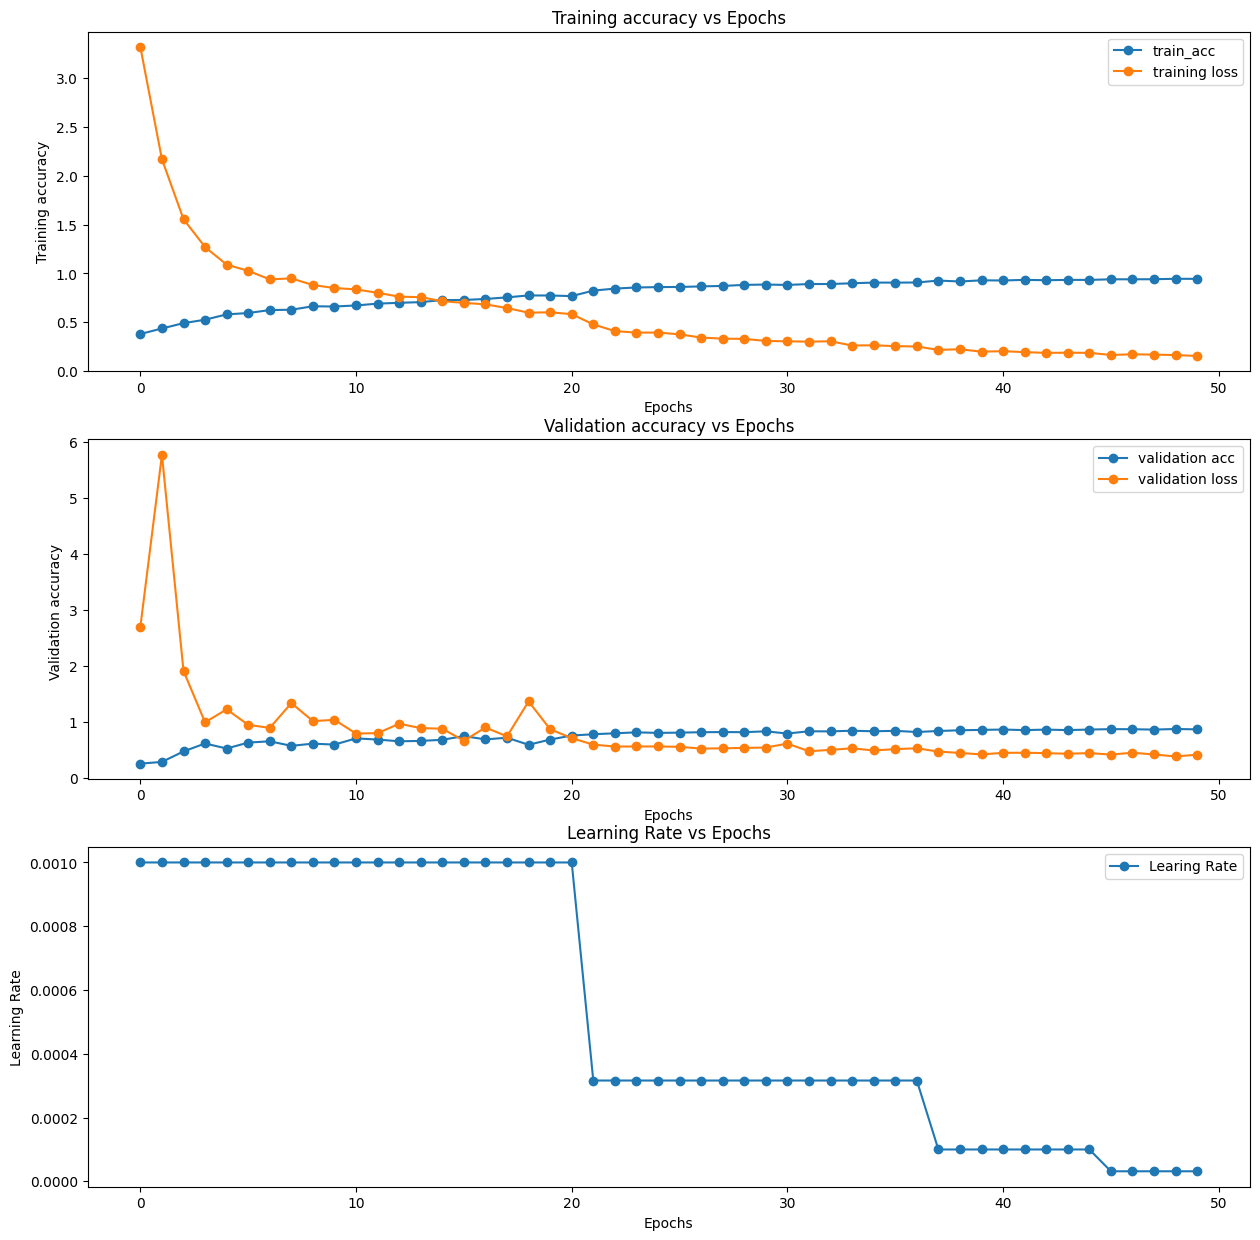

In [32]:

fig , ax = plt.subplots(ncols=1,nrows=3,figsize=(15,15))

ax[0].set_title("Training accuracy vs Epochs")
ax[0].plot(train_acc,'o-',label='train_acc')
ax[0].plot(train_loss,'-o',label='training loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training accuracy')
ax[0].legend(loc='best')


ax[1].set_title("Validation accuracy vs Epochs")
ax[1].plot(val_acc,'o-',label='validation acc')
ax[1].plot(val_loss,'-o',label='validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Validation accuracy ')
ax[1].legend(loc='best')

ax[2].set_title("Learning Rate vs Epochs")
ax[2].plot(learn_rate,'o-',label='Learing Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Learning Rate')
ax[2].legend(loc='best')

In [33]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'flower_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [35]:
cnn_mod.save('LesionDetection.keras')

In [36]:

predictions = cnn_mod.predict(X_test)


32/32 [==============================] - 9s 272ms/step


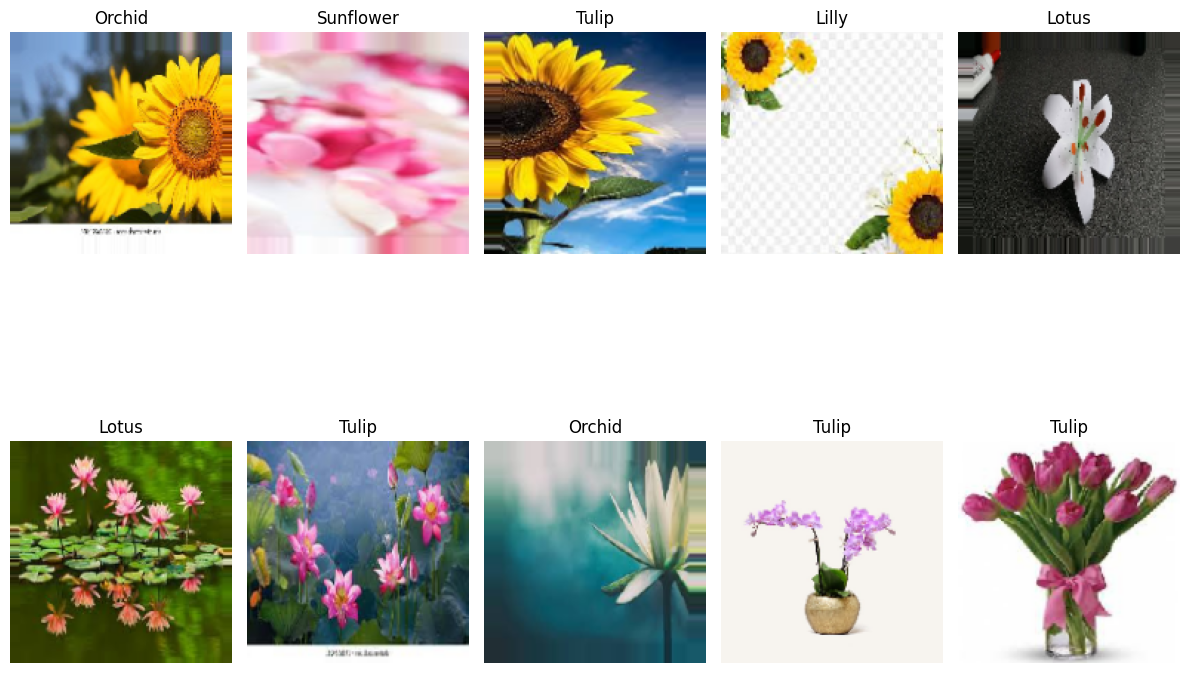

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(X_test[0][0][idx][:,:,:])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
#plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [39]:

test_loss, test_accuracy = cnn_mod.evaluate(X_test, batch_size=32)

32/32 [==============================] - 11s 338ms/step - loss: 0.4414 - accuracy: 0.8730


In [40]:

y_pred = np.argmax(predictions, axis=1)
y_true = X_test.classes

In [53]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

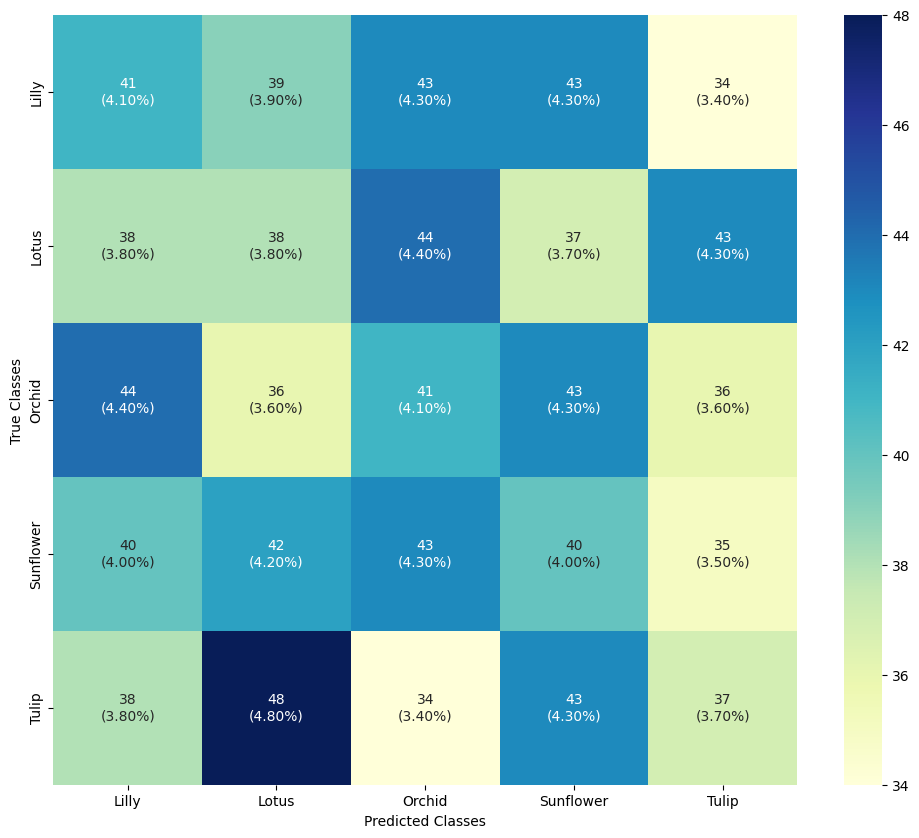

In [42]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(5,5)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()


In [43]:

errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [44]:
test_images = X_test.filenames
test_img = np.asarray(test_images)[errors]

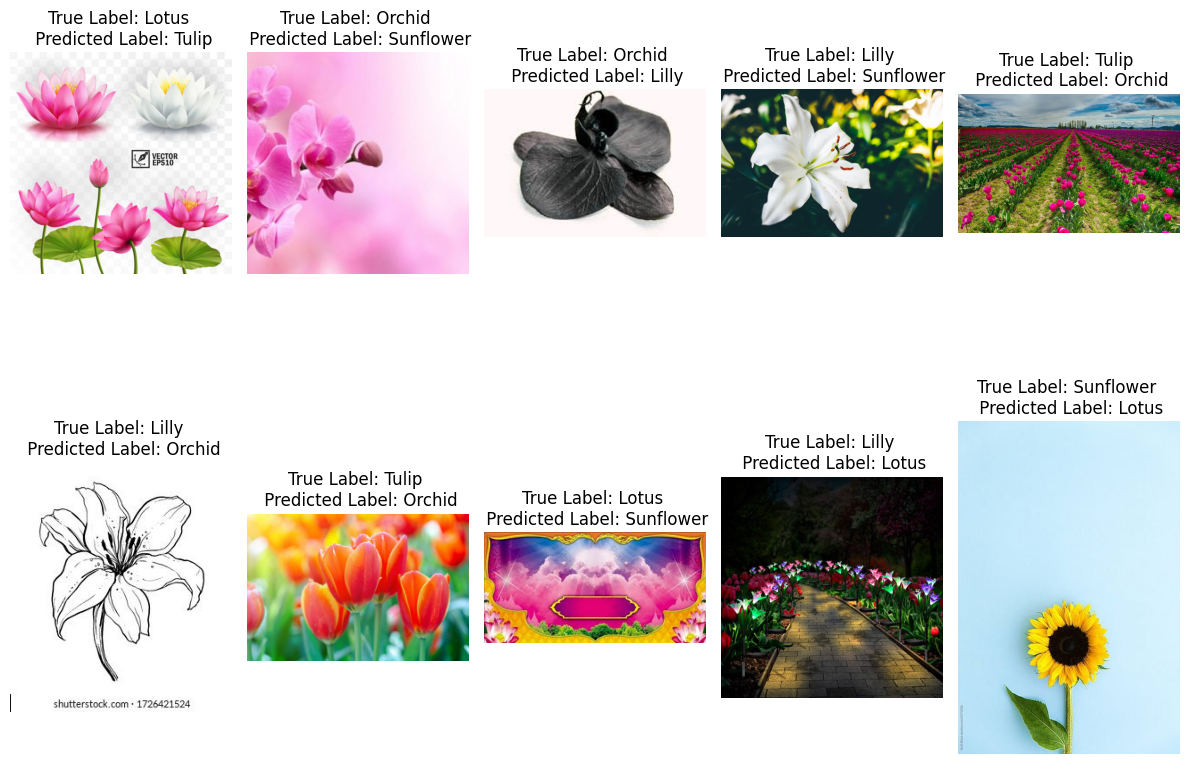

In [47]:
import os
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(data_path, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
#plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()